# News Headline Classification

### Importing Required libraries

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, LSTM, Dense, Input, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
physical_devices = tensorflow.config.list_physical_devices("GPU")
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)

### Importing the dataset

In [4]:
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)

In [5]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
df.shape

(200853, 6)

### Checking the dataset for null values

In [7]:
df.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

### Visualising the data

<Axes: xlabel='count', ylabel='category'>

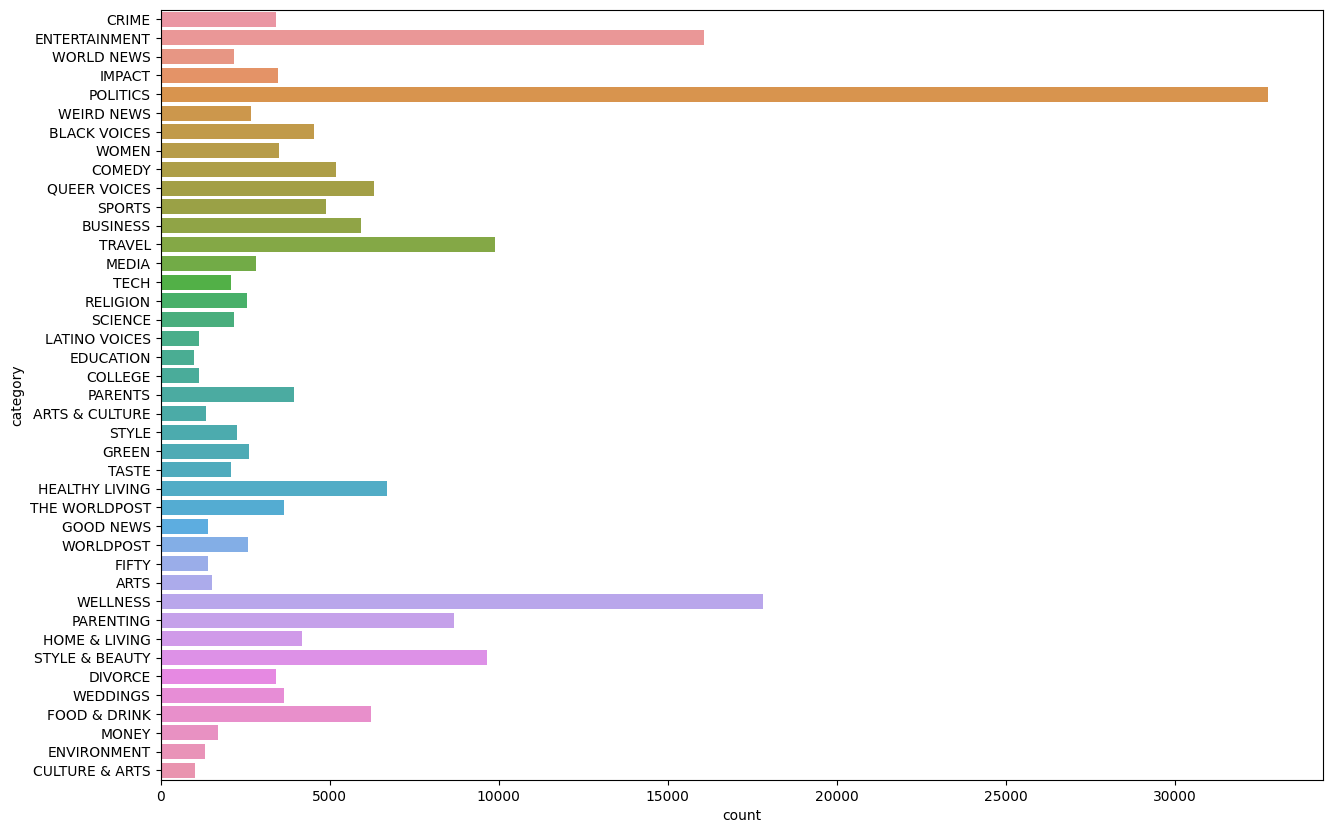

In [8]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.countplot(ax = ax, y=df['category'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


### Converting the category column into category_label_encoding

In [10]:
category_label_enc = {value: key for key, value in enumerate(df.category.unique())}
category_label_enc

{'CRIME': 0,
 'ENTERTAINMENT': 1,
 'WORLD NEWS': 2,
 'IMPACT': 3,
 'POLITICS': 4,
 'WEIRD NEWS': 5,
 'BLACK VOICES': 6,
 'WOMEN': 7,
 'COMEDY': 8,
 'QUEER VOICES': 9,
 'SPORTS': 10,
 'BUSINESS': 11,
 'TRAVEL': 12,
 'MEDIA': 13,
 'TECH': 14,
 'RELIGION': 15,
 'SCIENCE': 16,
 'LATINO VOICES': 17,
 'EDUCATION': 18,
 'COLLEGE': 19,
 'PARENTS': 20,
 'ARTS & CULTURE': 21,
 'STYLE': 22,
 'GREEN': 23,
 'TASTE': 24,
 'HEALTHY LIVING': 25,
 'THE WORLDPOST': 26,
 'GOOD NEWS': 27,
 'WORLDPOST': 28,
 'FIFTY': 29,
 'ARTS': 30,
 'WELLNESS': 31,
 'PARENTING': 32,
 'HOME & LIVING': 33,
 'STYLE & BEAUTY': 34,
 'DIVORCE': 35,
 'WEDDINGS': 36,
 'FOOD & DRINK': 37,
 'MONEY': 38,
 'ENVIRONMENT': 39,
 'CULTURE & ARTS': 40}

### Preprocessing the dataset

In [12]:
def get_seq(t, token, train=True, max_seq_length=0):
    seq = token.texts_to_sequences(t)
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), seq)))
    seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    return seq

def pi(df, lbl_map=None):
    df_copy = df.copy()
    df_copy = df_copy.loc[:, ['headline', 'category']]
    cat_sam = []

    for category in df['category'].unique():
        cat_slice = df.query("category == @category")
        cat_sam.append(cat_slice.sample(10000, random_state=1, replace = True))
        
    df_copy = pd.concat(cat_sam, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    
    df_copy['category'] = df_copy['category'].replace(lbl_map)
    
    y = df_copy['category']
    X = df_copy['headline']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)
    
    token = Tokenizer(num_words=10000)
    token.fit_on_texts(X_train)
    
    X_train = get_seq(X_train, token, train=True)
    X_test = get_seq(X_test, token, train=False, max_seq_length=X_train.shape[1])
    
    return X_train, X_test, y_train, y_test

In [13]:
x_train, x_test, y_train, y_test = pi(df, lbl_map=category_label_enc)

C:\Users\adity\AppData\Local\Temp\ipykernel_1604\553052485.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['category'] = df_copy['category'].replace(lbl_map)


In [14]:
x_train

array([[  15,    8,   14, ...,    0,    0,    0],
       [ 561,  717,  820, ...,    0,    0,    0],
       [5972, 5676,  837, ...,    0,    0,    0],
       ...,
       [ 129,    6,  974, ...,    0,    0,    0],
       [2907,   85,   11, ...,    0,    0,    0],
       [ 299, 4949, 7314, ...,    0,    0,    0]])

In [15]:
x_test

array([[2500,   75, 1560, ...,    0,    0,    0],
       [ 342,  227,    2, ...,    0,    0,    0],
       [  17,  332, 6159, ...,    0,    0,    0],
       ...,
       [1128,    7,  101, ...,    0,    0,    0],
       [ 270,   85, 1386, ...,    0,    0,    0],
       [3778, 9396, 3060, ...,    0,    0,    0]])

In [16]:
y_train

42845     36
59474      8
222862    34
54167     11
170584    26
          ..
259178     2
365838    39
131932    39
146867    37
121958    23
Name: category, Length: 307500, dtype: int64

In [17]:
y_test

258473    34
403774    21
366961    14
9745       3
22246     37
          ..
83375     21
349093    24
89917      8
392158    25
275855     6
Name: category, Length: 102500, dtype: int64

In [18]:
print('x_train shape = ', x_train.shape)
print('x_test shape = ', x_test.shape)

x_train shape =  (307500, 36)
x_test shape =  (102500, 36)


In [19]:
num_classes = len(df['category'].unique())
print(num_classes)

41


In [20]:
input_shape = (x_train.shape[1],)
print(input_shape)

(36,)


### Creating the model

In [21]:
vocab_size = 10000
embedding_dim = 64
max_length = x_train.shape[0]

In [64]:
def modelfn(input_shape = input_shape):
    x_input = Input(shape = input_shape)
    x = x_input
    x = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_length, trainable = True)(x)
    x = LSTM(64, return_sequences = True)(x)
    x = LSTM(128, return_sequences = True)(x)
    x = LSTM(256, return_sequences = True)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = 'modelfn')
    return model

In [65]:
lossfn = SparseCategoricalCrossentropy()
optimizerfn = Adam(0.0001)
callbackfn=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

In [66]:
model = modelfn(input_shape = input_shape)

In [67]:
model.compile(optimizer = optimizerfn, loss = lossfn, metrics = ["accuracy"])

### Model summary

In [68]:
model.summary()

Model: "modelfn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 36)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 36, 64)            640000    
                                                                 
 lstm_10 (LSTM)              (None, 36, 64)            33024     
                                                                 
 lstm_11 (LSTM)              (None, 36, 128)           98816     
                                                                 
 lstm_12 (LSTM)              (None, 36, 256)           394240    
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1179

### Training the model

In [69]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=100, callbacks = callbackfn)

Epoch 1/100
3844/3844 [==============================] - 62s 15ms/step - loss: 3.1567 - accuracy: 0.1208 - val_loss: 2.7023 - val_accuracy: 0.2368
Epoch 2/100
3844/3844 [==============================] - 57s 15ms/step - loss: 2.4064 - accuracy: 0.3294 - val_loss: 2.2287 - val_accuracy: 0.3906
Epoch 3/100
3844/3844 [==============================] - 57s 15ms/step - loss: 2.0728 - accuracy: 0.4325 - val_loss: 2.0280 - val_accuracy: 0.4500
Epoch 4/100
3844/3844 [==============================] - 56s 15ms/step - loss: 1.9119 - accuracy: 0.4788 - val_loss: 1.9308 - val_accuracy: 0.4785
Epoch 5/100
3844/3844 [==============================] - 58s 15ms/step - loss: 1.7938 - accuracy: 0.5118 - val_loss: 1.8230 - val_accuracy: 0.5077
Epoch 6/100
3844/3844 [==============================] - 56s 15ms/step - loss: 1.6696 - accuracy: 0.5439 - val_loss: 1.7255 - val_accuracy: 0.5358
Epoch 7/100
3844/3844 [==============================] - 57s 15ms/step - loss: 1.5621 - accuracy: 0.5707 - val_loss: 1

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

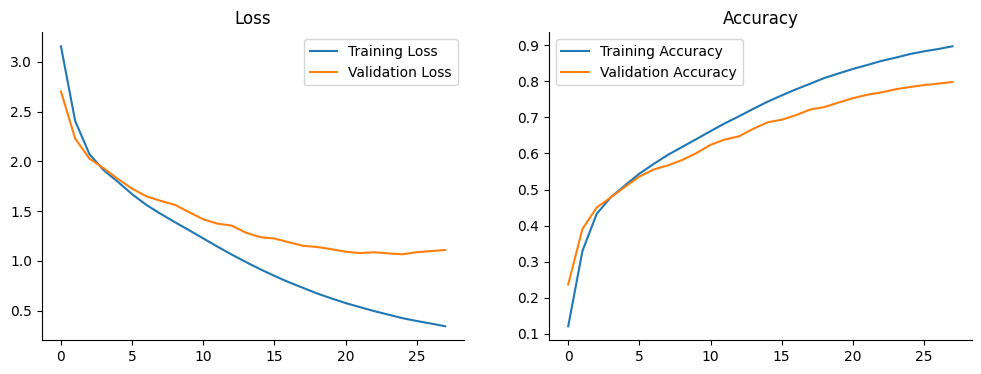

In [70]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

### Testing the model

In [71]:
model.evaluate(x_test, y_test)[1]

3204/3204 [==============================] - 22s 7ms/step - loss: 1.0797 - accuracy: 0.7810


0.781014621257782

In [72]:
x_test[0].shape

(36,)

In [73]:
y = np.argmax(model.predict(x_test)[0], axis=-1)

3204/3204 [==============================] - 19s 6ms/step


In [74]:
y

34

### Saving the model

Saving the model and weights for use in other applications

In [75]:
model_json = model.to_json()

In [76]:
with open('model_json.json','w') as json_file:
    json_file.write(model_json)

In [77]:
model.save_weights('model.h5')